In [118]:
import tifffile 
import matplotlib.pyplot as plt
import os
import numpy as np
import napari
import pandas as pd

from cellpose import models
from skimage.feature import blob_log
from skimage.util import invert
from skimage.exposure import is_low_contrast, adjust_gamma, adjust_log, equalize_hist
from skimage.filters import threshold_otsu, gaussian, threshold_yen, threshold_multiotsu, threshold_triangle, sobel
from skimage.measure import label
from skimage.color import label2rgb

import napari
import skimage.data
import skimage.filters
from napari.types import ImageData, LabelsData

from magicgui import magicgui

import tkinter as tk
from tkinter import filedialog


In [119]:
%gui qt

In [120]:
plt.rcParams['figure.figsize'] = [16, 10]

In [121]:
#   Removes labels that are on the border of the image
def filter_cropped_cells(masks):
    filtered_masks = np.zeros_like(masks)
    counter = 1
    for cell in np.unique(masks):
        if cell >0:
            single_cell = np.zeros_like(masks)
            single_cell = np.where(masks!=cell, single_cell, 1)
            if (np.sum(single_cell[0,:]) or
                np.sum(single_cell[:,0]) or
                np.sum(single_cell[masks.shape[0]-1,:]) or
                np.sum(single_cell[:,masks.shape[1]-1]))>1:
                masks[masks==cell]=0
    for cell in np.unique(masks):
        if cell >0:
            filtered_masks[masks==cell] = counter
            counter+=1
    return filtered_masks

def returnLipids(image):
    threshold = threshold_yen(image[0, :, :])
    thres = image[0, :, :].copy()

    thres[thres <threshold]=0
    lipid_labels= thres
    lipid_labels[lipid_labels>0]=1
    return lipid_labels


In [122]:


path = "April 14/LPS 24h 2.lsm"


root = tk.Tk()
root.withdraw()

path = filedialog.askopenfilename()

image = tifffile.imread(path)

In [127]:
# Use cellpose to generate the microglia roi and 

@magicgui(call_button = 'Generate Label', )
def Label_Gen(layer: ImageData,) -> LabelsData:
    if layer is not None:
        model = models.Cellpose(gpu=False, model_type='cyto')
        masks, _, _, _ = model.eval(image[1, :, :], diameter=225, channels=[0,0])
        label_img = filter_cropped_cells(masks)
        print("Max Cell Label: ", np.unique(label_img).max())
        return label_img

# create a viewer and add some images
viewer = napari.Viewer()
viewer.add_image(image[1, :, :], name="Microglia")
viewer.add_image(image[0, :, :], name="Lipid Dots", blending='additive', colormap='green')


# Add it to the napari viewer
viewer.window.add_dock_widget(Label_Gen)

napari.run()

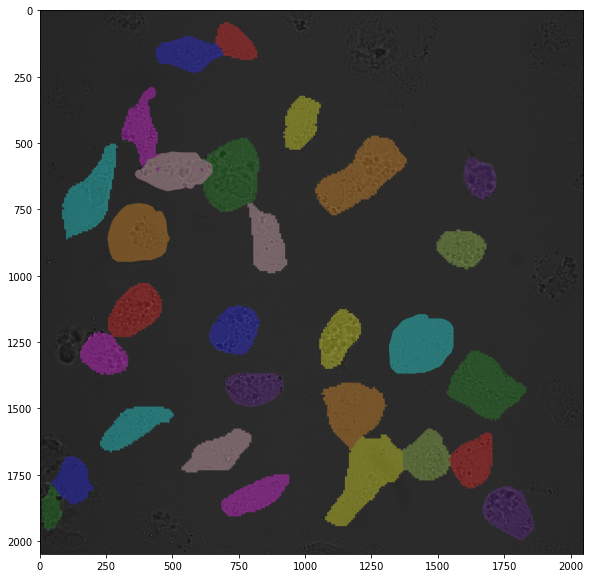

In [128]:
# View the segemented microglia
Cells = viewer.layers[2].data
color2 = label2rgb(Cells, image=image[1, :, :], bg_label=0)
plt.imshow(color2)

In [129]:
# Dictionary to store lipid arrays
lipid_dots = returnLipids(image)

# Generate lipid dot dictionary
lipid_cel_dict = {}
for cell in np.unique(Cells):
    if cell >0:
        dots = lipid_dots.copy()
        dots[Cells!=cell]=0
        lipid_cel_dict['Cell_{0}'.format(str(cell))]=dots


In [130]:
# Generate Pandas Dataframe for metrics
experiment_stats = pd.DataFrame(columns=['Experiment', 'Cell', 'Cell Area', 'Lipid Area', 'Lipid Number', 'Average Lipid Intensity'])
ch1 = image[0, :, :].copy()

for cell in np.unique(Cells):
        if cell >0:
            cell_stats ={}
            cell_id = 'Cell_{0}'.format(str(cell))
            cell_stats['Experiment'] = os.path.basename(path) 
            cell_stats['Cell'] = cell_id
            cell_area = Cells.copy()
            cell_area[cell_area!=cell]=0
            cell_area[cell_area>0] = 1
            cell_stats['Cell Area'] = np.sum(cell_area)
            cell_dots = lipid_cel_dict[cell_id]
            cell_stats['Lipid Area'] = np.sum(cell_dots)
            cell_stats['Lipid Number'] = np.unique(label(cell_dots)).max()
            cell_stats['Average Lipid Intensity'] = np.mean(ch1[cell_dots==1])
            experiment_stats = experiment_stats.append(cell_stats, ignore_index=True, sort=False)

            

/home/peter/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/peter/.local/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,Experiment,Cell,Cell Area,Lipid Area,Lipid Number,Average Lipid Intensity
0,LPS 24h 2.lsm,Cell_1,14814,70,5,16228.914286
1,LPS 24h 2.lsm,Cell_2,23280,17,3,15219.705882
2,LPS 24h 2.lsm,Cell_3,20159,797,13,25159.697616
3,LPS 24h 2.lsm,Cell_4,22600,2093,24,25669.935977
4,LPS 24h 2.lsm,Cell_5,44485,1003,19,18452.167498
5,LPS 24h 2.lsm,Cell_6,14062,411,14,16683.547445
6,LPS 24h 2.lsm,Cell_7,52059,1554,16,25400.495495
7,LPS 24h 2.lsm,Cell_8,38643,62,7,17130.935484
8,LPS 24h 2.lsm,Cell_9,25336,691,17,19454.483357
9,LPS 24h 2.lsm,Cell_10,20215,2249,26,22923.529569


In [131]:
# Save output of the processing

if not os.path.exists('Output'):
    os.makedirs('Output')
experiment_stats.to_csv('Output/'+os.path.basename(path)[:-4]+'_Stats')
np.save('Output/'+os.path.basename(path)[:-4]+"_Cell_Labels", Cells)
np.save('Output/'+os.path.basename(path)[:-4]+"_Threshold_Lipids", lipid_dots)

    


In [133]:
viewer = napari.Viewer()
viewer.add_image(image[1, :, :], name="Microglia")
viewer.add_image(image[0, :, :], name="Lipid Dots", blending='additive', colormap='green')
viewer.add_image(lipid_dots, name="Lipid Dots", blending='additive', colormap='red')


<Image layer 'Lipid Dots [1]' at 0x7f16147c5e20>